# Modeling 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 


# import additional libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# functions from .py file
import src.eda_functions as fun


# Machine Learning Models
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import r2_score, SCORERS
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# turn off warnings
import warnings
warnings.simplefilter('ignore', category = DeprecationWarning)
warnings.simplefilter('ignore', category = FutureWarning)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


read in merged_data file

In [20]:
data = pd.read_csv('../../data/train_set.csv')
val_set = pd.read_csv('../../data/val_set.csv')
test_set = pd.read_csv('../../data/test_set.csv')

In [21]:
data = data.drop(['number_students_who_took_ap_classes_grade_12_total', 'number_students_who_took_ap_classes_grade_11_total', 'number_students_who_took_ap_classes_grade_10_total'], axis=1)

In [23]:
val_set = val_set.drop(['number_students_who_took_ap_classes_grade_12_total', 'number_students_who_took_ap_classes_grade_11_total', 'number_students_who_took_ap_classes_grade_10_total'], axis=1)

In [24]:
test_set = test_set.drop(['number_students_who_took_ap_classes_grade_12_total', 'number_students_who_took_ap_classes_grade_11_total', 'number_students_who_took_ap_classes_grade_10_total'], axis=1)

In [25]:
data['cohort'] = data['cohort'].astype('object')

# 1. Replace nans with zeros

In [26]:
zeros = data.loc[:, ('high_school_4_year_graduation_rate_total',
                        'high_school_5_year_graduation_rate_total',
                        'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                        'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
                        'percent_9th_grade_on_track')]

for zero in zeros:
    data[zero].fillna(0, inplace=True)
    
data.isnull().sum().sort_values(ascending=False)

teacher_retention_rate                                                        732
pupil_teacher_ratio_high_school                                               682
avg_class_size_high_school                                                     34
high_school_dropout_rate_total                                                  2
county                                                                          0
percent_student_enrollment_white                                                0
grades_served                                                                   0
school_type                                                                     0
district_size                                                                   0
district_type                                                                   0
percent_9th_grade_on_track                                                      0
city                                                                            0
percent_student_

# 2. Replace nans with mean()


Use SimpleImputer to replace NaNs with mean value

In [27]:
# identify features
train_features = data.loc[:, ('teacher_retention_rate', 'pupil_teacher_ratio_high_school', 
                              'avg_class_size_high_school', 'high_school_dropout_rate_total', 
                             'total_number_of_school_days', 'student_attendance_rate', 'student_chronic_truancy_rate')]

val_features = val_set.loc[:, ('teacher_retention_rate', 'pupil_teacher_ratio_high_school', 
                                'avg_class_size_high_school', 'high_school_dropout_rate_total', 
                               'total_number_of_school_days', 'student_attendance_rate', 'student_chronic_truancy_rate')]

test_features = test_set.loc[:, ('teacher_retention_rate', 'pupil_teacher_ratio_high_school', 
                                 'avg_class_size_high_school', 'high_school_dropout_rate_total', 
                                 'total_number_of_school_days','student_attendance_rate', 'student_chronic_truancy_rate' )]

In [28]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X_imp= imputer.transform(train_features)
X_v_imp = imputer.transform(val_features)
X_test_imp = imputer.transform(test_features)


#### Train set

In [29]:
# convert to DataFrame
X_imp_processed = pd.DataFrame(X_imp, columns=train_features.columns)
# replace NaNs with mean values

data.loc[:, ('teacher_retention_rate', 'pupil_teacher_ratio_high_school', 
            'avg_class_size_high_school', 'high_school_dropout_rate_total'
            )]= X_imp_processed.loc[:, ('teacher_retention_rate', 'pupil_teacher_ratio_high_school', 
                                        'avg_class_size_high_school', 'high_school_dropout_rate_total')]

#### Val set

In [30]:
# convert to DataFrame
X_v_imp_processed = pd.DataFrame(X_v_imp, columns=val_features.columns)
# replace NaNs with mean values

val_set.loc[:, ('teacher_retention_rate', 'pupil_teacher_ratio_high_school', 
            'avg_class_size_high_school', 'high_school_dropout_rate_total', 'total_number_of_school_days', 
                'student_attendance_rate', 'student_chronic_truancy_rate'
            )]= X_v_imp_processed.loc[:, ('teacher_retention_rate', 'pupil_teacher_ratio_high_school', 
            'avg_class_size_high_school', 'high_school_dropout_rate_total', 'total_number_of_school_days', 
                                          'student_attendance_rate', 'student_chronic_truancy_rate')]

val_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 30 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      721 non-null    int64  
 1   rcdts                                                                       721 non-null    object 
 2   school_name                                                                 721 non-null    object 
 3   district                                                                    721 non-null    object 
 4   city                                                                        721 non-null    object 
 5   county                                                                      721 non-null    object 
 6   district_type                                     

#### Test set

In [31]:
# convert to DataFrame
X_test_imp_processed = pd.DataFrame(X_test_imp, columns=test_features.columns)
# replace NaNs with mean values

test_set.loc[:, ('teacher_retention_rate', 'pupil_teacher_ratio_high_school', 
                 'avg_class_size_high_school', 'high_school_dropout_rate_total', 'total_number_of_school_days','student_attendance_rate', 'student_chronic_truancy_rate'
            )]= X_test_imp_processed.loc[:, ('teacher_retention_rate', 'pupil_teacher_ratio_high_school', 
                'avg_class_size_high_school', 'high_school_dropout_rate_total', 'total_number_of_school_days', 
                'student_attendance_rate', 'student_chronic_truancy_rate')]

In [32]:
data_num = data.select_dtypes(['float64', 'int64'])
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403 entries, 0 to 3402
Data columns (total 20 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   percent_student_enrollment_white                                            3403 non-null   float64
 1   percent_student_enrollment_black_or_african_american                        3403 non-null   float64
 2   percent_student_enrollment_hispanic_or_latino                               3403 non-null   float64
 3   percent_student_enrollment_asian                                            3403 non-null   float64
 4   percent_student_enrollment_native_hawaiian_or_other_pacific_islander        3403 non-null   float64
 5   percent_student_enrollment_american_indian_or_alaska_native                 3403 non-null   float64
 6   percent_student_enrollment_two_or_more_races    

# Train Test Split
- Train set = data_df
- Validation set = hs_18
- Test set = hs_19

In [33]:
X_train = data.drop('high_school_4_year_graduation_rate_total', axis=1)
y_train = data.high_school_4_year_graduation_rate_total


X_val = val_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_val = val_set.high_school_4_year_graduation_rate_total

X_test = test_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_test = test_set.high_school_4_year_graduation_rate_total

In [34]:
X_val['cohort'] = X_val['cohort'].astype('category')
X_test['cohort'] = X_test['cohort'].astype('category')

# Scaling Numeric features
- Standard Scaler?
- MinMaxScaler?

In [67]:
X_train_num = X_train.select_dtypes(['float64', 'int64'])
X_val_num = X_val.select_dtypes(['float64', 'int64'])
X_test_num = X_test.select_dtypes(['float64', 'int64'])

In [60]:
X_train_num

,percent_student_enrollment_white,percent_student_enrollment_black_or_african_american,percent_student_enrollment_hispanic_or_latino,percent_student_enrollment_asian,percent_student_enrollment_native_hawaiian_or_other_pacific_islander,percent_student_enrollment_american_indian_or_alaska_native,percent_student_enrollment_two_or_more_races,number_student_enrollment,total_number_of_school_days,student_attendance_rate,student_chronic_truancy_rate,high_school_dropout_rate_total,high_school_5_year_graduation_rate_total,avg_class_size_high_school,pupil_teacher_ratio_high_school,teacher_retention_rate,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track
0,98.2,0.0,0.0,0.0,0.0,0.5,1.4,222,174,96.0,2.3,1.4,94.1,11.1,17.9,87.1,0.0,0.0,0.0
1,99.0,0.0,0.3,0.0,0.0,0.0,0.7,288,176,95.8,1.8,0.5,93.8,29.5,17.9,87.1,0.0,0.0,0.0
2,97.8,0.0,0.0,0.0,0.4,0.0,1.8,273,175,93.3,5.7,0.0,89.7,12.7,17.9,87.1,0.0,0.0,0.0
3,98.6,0.5,0.0,0.5,0.0,0.5,0.0,217,175,95.4,1.0,0.5,88.6,10.9,17.9,87.1,0.0,0.0,0.0
4,87.0,8.0,1.5,0.6,0.0,0.1,2.8,1428,176,92.0,12.8,4.6,88.5,20.1,17.9,87.1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3398,79.0,6.0,9.3,2.8,0.0,0.1,2.7,2916,175,95.3,0.2,0.1,96.7,23.6,20.9,79.6,88.9,86.9,96.0
3399,84.7,1.8,10.4,0.6,0.1,0.2,2.2,1898,175,94.8,0.4,0.2,97.2,23.7,20.9,82.6,88.7,86.5,93.7
3400,91.3,0.0,5.5,0.4,0.0,0.0,2.8,470,174,95.7,3.7,1.7,95.8,15.3,15.9,86.2,60.8,56.7,90.8
3401,19.7,26.9,40.9,8.1,0.3,0.2,3.9,3469,175,88.5,28.3,2.2,84.3,17.6,20.7,88.6,67.4,63.1,87.3


In [ ]:
X_train_num = X_train.['high_school_5_year_graduation_rate_total', 
'student_attendance_rate', 
'number_students_who_took_ap_classes_grade_12_total', 
'high_school_dropout_rate_total', 
'number_student_enrollment', 
'percent_student_enrollment_white', 
'pupil_teacher_ratio_high_school', 
'percent_student_enrollment_american_indian_or_alaska_native', 
'total_number_of_school_days' , 
'percent_student_enrollment_asian', 
'number_students_who_took_ap_classes_grade_11_total', 
'number_students_who_took_ap_classes_grade_10_total', 
'percent_student_enrollment_two_or_more_races', 
'percent_student_enrollment_black_or_african_american', 
'percent_student_enrollment_hispanic_or_latino', 
'percent_student_enrollment_native_hawaiian_or_other_pacific_islander']

In [59]:
X_test_num = X_test[['high_school_5_year_graduation_rate_total', 
'student_attendance_rate', 
'number_students_who_took_ap_classes_grade_12_total', 
'high_school_dropout_rate_total', 
'number_student_enrollment', 
'percent_student_enrollment_white', 
'pupil_teacher_ratio_high_school', 
'percent_student_enrollment_american_indian_or_alaska_native', 
'total_number_of_school_days' , 
'percent_student_enrollment_asian', 
'number_students_who_took_ap_classes_grade_11_total', 
'number_students_who_took_ap_classes_grade_10_total', 
'percent_student_enrollment_two_or_more_races', 
'percent_student_enrollment_black_or_african_american', 
'percent_student_enrollment_hispanic_or_latino', 
'percent_student_enrollment_native_hawaiian_or_other_pacific_islander']]

KeyError: "['number_students_who_took_ap_classes_grade_12_total', 'number_students_who_took_ap_classes_grade_11_total', 'number_students_who_took_ap_classes_grade_10_total'] not in index"

In [36]:
X_train_index = X_train.index
X_val_index = X_val.index
X_test_index = X_test.index

In [37]:
ss = StandardScaler()
X_train_sc = pd.DataFrame(ss.fit_transform(X_train_num), columns=X_train_num.columns, index=X_train_index)
X_val_sc = pd.DataFrame(ss.transform(X_val_num), columns=X_val_num.columns, index=X_val_index)
X_test_sc = pd.DataFrame(ss.transform(X_test_num), columns=X_test_num.columns, index=X_test_index)


# 2. Encoding Categorical features

In [38]:
X_train_cat = X_train[['district_type', 'district_size', 'school_type']]
X_val_cat = X_val[['district_type', 'district_size', 'school_type']]

In [39]:
#let's change these objects to categories
X_train_cat.loc[:, ('district_type', 'district_size', 'school_type')].astype('category')
X_val_cat.loc[:, ('district_type', 'district_size', 'school_type')].astype('category')
#X_test_cat.loc[:, ('district_type', 'district_size', 'school_type')].astype('category')

,district_type,district_size,school_type
0,UNIT,MEDIUM,HIGH SCHOOL
1,UNIT,MEDIUM,HIGH SCHOOL
2,UNIT,MEDIUM,HIGH SCHOOL
3,UNIT,MEDIUM,HIGH SCHOOL
4,UNIT,LARGE,HIGH SCHOOL
...,...,...,...
716,UNIT,MEDIUM,HIGH SCHOOL
717,UNIT,MEDIUM,HIGH SCHOOL
718,UNIT,MEDIUM,HIGH SCHOOL
719,UNIT,LARGE,HIGH SCHOOL


In [40]:
X_train_cat.district_type = X_train_cat.district_type.str.rstrip()
X_train_cat.district_size = X_train_cat.district_size.str.rstrip()
X_train_cat.school_type = X_train_cat.school_type.str.rstrip()
#X_train_cat.grades_served = X_train_cat.grades_served.str.rstrip()


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
X_val_cat.district_type.str.rstrip()
X_val_cat.district_size.str.rstrip()
X_val_cat.school_type.str.rstrip()

0      HIGH SCHOOL
1      HIGH SCHOOL
2      HIGH SCHOOL
3      HIGH SCHOOL
4      HIGH SCHOOL
          ...     
716    HIGH SCHOOL
717    HIGH SCHOOL
718    HIGH SCHOOL
719    HIGH SCHOOL
720    HIGH SCHOOL
Name: school_type, Length: 721, dtype: object

In [43]:
#encode the categoricals
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train_cat)
X_train_ohe = ohe.transform(X_train_cat).toarray()
X_val_ohe = ohe.transform(X_val_cat).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
X_train_processed = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train_cat.columns))
X_val_processed = pd.DataFrame(X_val_ohe, columns=ohe.get_feature_names(X_val_cat.columns))

X_train_processed.shape


(3403, 5)

In [44]:
X_train_all = pd.concat([X_train_sc, X_train_processed], axis=1)
X_val_all = pd.concat([X_val_sc, X_val_processed], axis=1)
#X_test_all = pd.concat([X_test_sc, X_test_processed], axis=1)


In [ ]:
['high_school_5_year_graduation_rate_total', 
'student_attendance_rate', 
'number_students_who_took_ap_classes_grade_12_total', 
'high_school_dropout_rate_total', 
'number_student_enrollment', 
'percent_student_enrollment_white', 
'pupil_teacher_ratio_high_school', 
'percent_student_enrollment_american_indian_or_alaska_native', 
'total_number_of_school_days' , 
'percent_student_enrollment_asian', 
'number_students_who_took_ap_classes_grade_11_total', 
'number_students_who_took_ap_classes_grade_10_total', 
'percent_student_enrollment_two_or_more_races', 
'percent_student_enrollment_black_or_african_american', 
'percent_student_enrollment_hispanic_or_latino', 
'percent_student_enrollment_native_hawaiian_or_other_pacific_islander']

# 6. Test models
- Linear Regression
- Random Forest
- Gradient Boost
- Lasso
- Ridge
- SVM
- KNN

In [46]:
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_eval(model):
    
    # Train the model
    model.fit(X_train_all, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_val_all)
    model_r2 = r2_score(y_val, model_pred)
    # Return the performance metric

    return model_r2

In [47]:
linreg = LinearRegression()
linreg_r2 = fit_and_eval(linreg)

print('Linear Regression Performance on the test set: R2 = %0.4f' % linreg_r2)

Linear Regression Performance on the test set: R2 = 0.4740


In [48]:
random_forest = RandomForestRegressor(random_state=19)
random_forest_r2 = fit_and_eval(random_forest)


print('Random Forest Performance on the test set: R2 = %0.4f' % random_forest_r2)

Random Forest Performance on the test set: R2 = 0.4609


In [49]:
extra_trees = ExtraTreesRegressor(random_state=19)

extra_trees_r2 = fit_and_eval(extra_trees)

print('Extra Trees Performance on the test set: R2 = %0.4f' % extra_trees_r2)

Extra Trees Performance on the test set: R2 = 0.5571


In [50]:
grad_boost = GradientBoostingRegressor(random_state=19)

grad_boost_r2 = fit_and_eval(grad_boost)

print('Gradient Boosted Performance on the test set: R2 = %0.4f' % grad_boost_r2)

Gradient Boosted Performance on the test set: R2 = 0.5644


In [51]:
# Create the model
lasso = Lasso(random_state=19)

lasso_r2 = fit_and_eval(lasso)

print('Lasso model Performance on the test set: R2 = %0.4f' % lasso_r2)

Lasso model Performance on the test set: R2 = 0.4903


In [52]:
ridge = Ridge(random_state=19)
ridge_r2 = fit_and_eval(ridge)

print('Ridge Model Performance on the test set: R2 = %0.4f' % ridge_r2)

Ridge Model Performance on the test set: R2 = 0.5307


In [53]:
svr = SVR()
svr_r2 = fit_and_eval(svr)

print('Support Vector Machine Regression Performance on the test set: R2 = %0.4f' % svr_r2)

Support Vector Machine Regression Performance on the test set: R2 = 0.3993


In [54]:
knn = KNeighborsRegressor()
knn_r2 = fit_and_eval(knn)

print('K-Nearest Neighbors Regression Performance on the test set: R2 = %0.4f' % knn_r2)

K-Nearest Neighbors Regression Performance on the test set: R2 = 0.4988


# 7. Select model

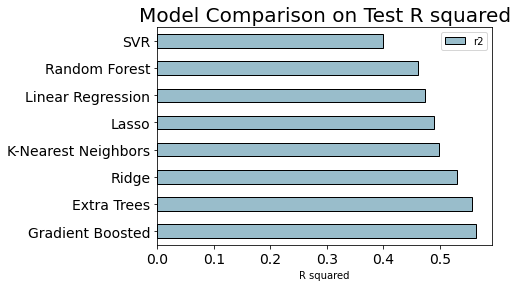

In [55]:

# Dataframe to hold the results
           
model_comparison = pd.DataFrame({'model': ['Linear Regression','Random Forest',
                                           'Extra Trees','Gradient Boosted',
                                           'Lasso', 'Ridge', 'SVR','K-Nearest Neighbors'],
                                 'r2': [linreg_r2, random_forest_r2, extra_trees_r2, 
                                         grad_boost_r2, lasso_r2, ridge_r2, svr_r2, knn_r2]})

# Horizontal bar chart of test r2
model_comparison.sort_values('r2', ascending = False).plot(x = 'model', y = 'r2', kind = 'barh',
                                                           color = '#99BDCB', edgecolor = 'black')

# Plot formatting

#plt.figure(figsize=(20, 16)


plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('R squared'); plt.xticks(size = 14)
plt.title('Model Comparison on Test R squared', size = 20);

# 8. grid search w cross val

In [56]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [ ]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 19)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=19)

In [ ]:
# Find the best combination of settings
random_cv.best_estimator_


# 9. train

# 10. evalutate on test set

In [ ]:
# Make predictions on the test set using default and final model
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

# 11. Model interpretation
- feature impolrtances
 - create df & visualize
- plot single decision tree
- LIME

In [ ]:
lin_reg_model = LinearRegression()
baseline_cross_val_score = cross_val_score(lin_reg_model, X_train, y_train)
baseline_cross_val_score